# 训练

In [1]:
# setsid python train_yolov8.py > train.log 2>&1 &

# 变量定义

In [7]:
model_name = 'yolov8n'
model_stru = '-p2'
model_cfg = '_train_val'
exp_name = f'{model_name}{model_stru}{model_cfg}'
USE_VAL = 'val' in model_cfg

best_model_path = f'runs/detect/{exp_name}/train/weights/best.pt'
train_log_path = f'runs/detect/{exp_name}/train/results.csv'
print(f'{best_model_path}')
print(f'{train_log_path}')

runs/detect/yolov8n-p2_train_val/train/weights/best.pt
runs/detect/yolov8n-p2_train_val/train/results.csv


# 日志分析-验证

['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


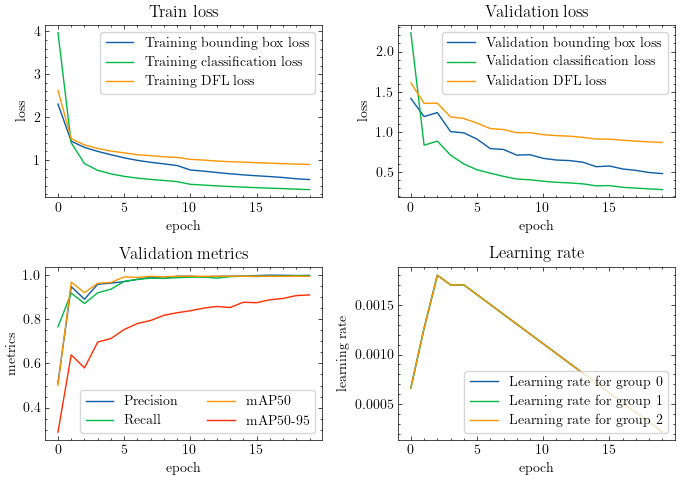

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

plt.rcParams['text.usetex'] = False
plt.style.use('science')

re = pd.read_csv(train_log_path)
columns = [i.strip() for i in re.columns.tolist()]
re.columns = columns
print(re.columns.to_list())

fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharex=False, dpi=100)
axes = axes.flatten()

# 第一个子图
axes[0].plot(re.index, re['train/box_loss'],
             label='Training bounding box loss')
axes[0].plot(re.index, re['train/cls_loss'],
             label='Training classification loss')
axes[0].plot(re.index, re['train/dfl_loss'], label='Training DFL loss')
axes[0].legend(loc='upper right', frameon=True)

# 第二个子图
axes[1].plot(re.index, re['val/box_loss'],
             label='Validation bounding box loss')
axes[1].plot(re.index, re['val/cls_loss'],
             label='Validation classification loss')
axes[1].plot(re.index, re['val/dfl_loss'], label='Validation DFL loss')
axes[1].legend(loc='upper right', frameon=True)

# 第三个子图
axes[2].plot(re.index, re['metrics/precision(B)'],
             label='Precision')
axes[2].plot(re.index, re['metrics/recall(B)'], label='Recall')
axes[2].plot(re.index, re['metrics/mAP50(B)'], label='mAP50')
axes[2].plot(re.index, re['metrics/mAP50-95(B)'], label='mAP50-95')
axes[2].legend(loc='lower right', ncol=2, frameon=True)

# 第四个子图
axes[3].plot(re.index, re['lr/pg0'], label='Learning rate for group 0')
axes[3].plot(re.index, re['lr/pg1'], label='Learning rate for group 1')
axes[3].plot(re.index, re['lr/pg2'], label='Learning rate for group 2')
axes[3].legend(loc='lower right', frameon=True)

# 参数配置
axes[0].set_xlabel('epoch')
axes[1].set_xlabel('epoch')
axes[2].set_xlabel('epoch')
axes[3].set_xlabel('epoch')

axes[0].set_ylabel('loss')
axes[1].set_ylabel('loss')
axes[2].set_ylabel('metrics')
axes[3].set_ylabel('learning rate')

axes[0].set_title('Train loss')
axes[1].set_title('Validation loss')
axes[2].set_title('Validation metrics')
axes[3].set_title('Learning rate')

plt.tight_layout()
plt.save_fig(f'results/figs/train_log_{exp_name}.jpg')
plt.show()

# 测试

In [3]:
from ultralytics import YOLO
import torch

# 加载模型
model = YOLO(best_model_path)

# 保存结果
test_metrics = {}

# 在各测试集进行测试
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在测试: {data_type}')
    if not USE_VAL:
        data_yaml = f'datasets/cfg/lard_{data_type}.yaml'
    else:
        data_yaml = f'datasets/cfg/lard_val_{data_type}.yaml'

    print(data_yaml)

    metrics = model.val(
        data=data_yaml,
        imgsz=640,
        batch=32,
        save_json=True,  # 保存预测结果JSON
        conf=0.5,  # 检测的目标置信度阈值
        iou=0.5,  # NMS使用的IOU阈值
        device=0,
        split='test',  # val时使用的数据集划分
        name=f'{exp_name}/val_{data_type}'
    )

    test_metrics[data_type] = metrics

torch.cuda.empty_cache()

Ultralytics YOLOv8.0.202 🚀 Python-3.9.7 torch-1.10.2+cu111 CUDA:0 (NVIDIA GeForce GTX 1070, 8112MiB)


正在测试: test_synth
datasets/cfg/lard_val_test_synth.yaml


YOLOv8n-p2 summary (fused): 207 layers, 2921172 parameters, 0 gradients, 12.2 GFLOPs
val: Scanning /home/yeli/yeli/data/lard/YoloFormat/test_synth/labels.cache... 2212 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2212/2212 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]
                   all       2212       2212      0.984      0.955      0.975      0.772
Speed: 0.3ms preprocess, 6.2ms inference, 0.0ms loss, 0.4ms postprocess per image
Saving runs/detect/yolov8n-p2_train_val_TEST/val_test_synth/predictions.json...
Results saved to runs/detect/yolov8n-p2_train_val_TEST/val_test_synth
Ultralytics YOLOv8.0.202 🚀 Python-3.9.7 torch-1.10.2+cu111 CUDA:0 (NVIDIA GeForce GTX 1070, 8112MiB)


正在测试: test_real_nominal
datasets/cfg/lard_val_test_real_nominal.yaml


val: Scanning /home/yeli/yeli/data/lard/YoloFormat/test_real_nominal/labels.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [01:42<00:00,  2.19s/it]
                   all       1500       1500      0.915      0.733       0.84      0.631
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Saving runs/detect/yolov8n-p2_train_val_TEST/val_test_real_nominal/predictions.json...
Results saved to runs/detect/yolov8n-p2_train_val_TEST/val_test_real_nominal
Ultralytics YOLOv8.0.202 🚀 Python-3.9.7 torch-1.10.2+cu111 CUDA:0 (NVIDIA GeForce GTX 1070, 8112MiB)


正在测试: test_real_edge
datasets/cfg/lard_val_test_real_edge.yaml


val: Scanning /home/yeli/yeli/data/lard/YoloFormat/test_real_edge/labels.cache... 311 images, 0 backgrounds, 0 corrupt: 100%|██████████| 311/311 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]
                   all        311        311      0.884      0.418      0.656      0.456
Speed: 0.6ms preprocess, 5.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Saving runs/detect/yolov8n-p2_train_val_TEST/val_test_real_edge/predictions.json...
Results saved to runs/detect/yolov8n-p2_train_val_TEST/val_test_real_edge


# 评估

In [4]:
import os
import json
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
plt.style.use('science')


def get_name_2_id(annotation_file: str) -> dict:
    # 获取一个字典 name_2_id {图片名(无拓展名): 图片id}
    coco = COCO(annotation_file=annotation_file)
    img_ids = coco.getImgIds()
    name_2_id = {}
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        filename = os.path.splitext(img_info['file_name'])[0]  # 无拓展名的文件名
        name_2_id[filename] = img_id
    return name_2_id


# 保存评价结果
coco_evals = {}

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/detect/{exp_name}/val_{data_type}/predictions.json'
    prediction_modified_file = f'runs/detect/{exp_name}/val_{data_type}/predictions_modified.json'

    # 修改json文件
    name_2_id = get_name_2_id(annotation_file)
    with open(prediction_file, 'r') as f:
        pred = json.load(f)
    for item in pred:
        item['image_id'] = name_2_id[item['image_id']]
    with open(prediction_modified_file, 'w') as f:
        json.dump(pred, f)

    # 指标计算
    coco_true = COCO(annotation_file=annotation_file)
    coco_pre = coco_true.loadRes(resFile=prediction_modified_file)

    coco_evaluator = COCOeval(
        cocoGt=coco_true, cocoDt=coco_pre, iouType="bbox")
    coco_evaluator.evaluate()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    coco_evals[data_type] = coco_evaluator

正在评价: test_synth
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.52s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.824
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.763
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

In [5]:
import pandas as pd

metrics = [
    "AP (IoU=0.50:0.95, area=all, maxDets=100)",
    "AP (IoU=0.50, area=all, maxDets=100)",
    "AP (IoU=0.75, area=all, maxDets=100)",
    "AP (IoU=0.50:0.95, area=small, maxDets=100)",
    "AP (IoU=0.50:0.95, area=medium, maxDets=100)",
    "AP (IoU=0.50:0.95, area=large, maxDets=100)",
    "AR (IoU=0.50:0.95, area=all, maxDets=1)",
    "AR (IoU=0.50:0.95, area=all, maxDets=10)",
    "AR (IoU=0.50:0.95, area=all, maxDets=100)",
    "AR (IoU=0.50:0.95, area=small, maxDets=100)",
    "AR (IoU=0.50:0.95, area=medium, maxDets=100)",
    "AR (IoU=0.50:0.95, area=large, maxDets=100)"
]

all_metrics = {}
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:
    cocoEval = coco_evals[data_type]
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=metrics)
display(all_metrics.round(3))

,test_synth,test_real_nominal,test_real_edge
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.707,0.503,0.272
"AP (IoU=0.50, area=all, maxDets=100)",0.948,0.716,0.420
"AP (IoU=0.75, area=all, maxDets=100)",0.824,0.558,0.291
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.135,0.063
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.582,0.353,0.157
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.763,0.723,0.376
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.745,0.530,0.292
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.746,0.534,0.292
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.746,0.534,0.292
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.156,0.077


test_synth
precision.shape=(10, 101, 1, 4, 3), recall.shape=(10, 1, 4, 3)


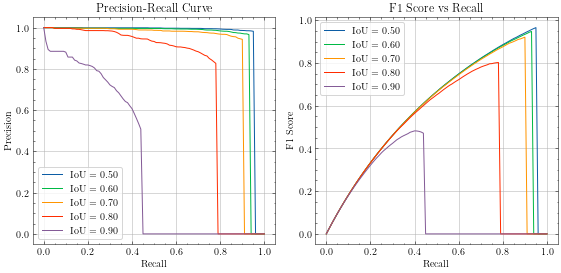

test_real_nominal
precision.shape=(10, 101, 1, 4, 3), recall.shape=(10, 1, 4, 3)


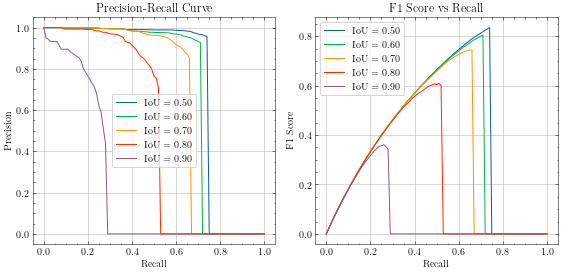

test_real_edge
precision.shape=(10, 101, 1, 4, 3), recall.shape=(10, 1, 4, 3)


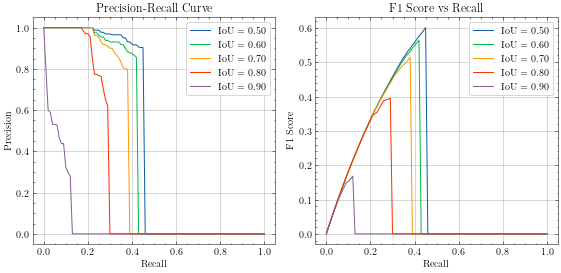

In [9]:
for key, coco_evaluator in coco_evals.items():

    print(key)

    precision = coco_evaluator.eval['precision']
    recall = coco_evaluator.eval['recall']

    print(f"{precision.shape=}, {recall.shape=}")

    # Assuming we have 5D precision data and 4D recall data from coco_eval
    # precision.shape should be (10, 101, num_classes, 4, 3)
    # recall.shape should be (10, num_classes, 4, 3)

    # num_iou_thresholds = 10  # Usually 10 IoU thresholds from 0.5 to 0.95
    # num_recall_levels = 101  # Usually 101 recall levels from 0 to 1
    # num_classes = 2  # Assuming 2 classes for demonstration
    # num_areas = 4   # Usually 4 areas ('all', 'small', 'medium', 'large')
    # num_max_dets = 3  # Usually 3 max detections [1, 10, 100]

    iou_indices = [0, 2, 4, 6, 8]
    # iou_indices = range(10)

    # 选择具体类别/区域/最大检测量
    class_index = 0
    area_index = 0
    max_dets_index = 2

    # 初始化图像
    plt.figure(figsize=(8, 4))

    # Precision-Recall曲线
    plt.subplot(1, 2, 1)
    for iou_index in iou_indices:
        selected_precision = precision[iou_index, :,
                                       class_index, area_index, max_dets_index]
        selected_recall = np.linspace(0, 1, len(selected_precision))
        plt.plot(selected_recall, selected_precision,
                 label=f'IoU = {0.5 + iou_index * 0.05:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(frameon=True)
    plt.grid(True)

    # F1-Recall曲线
    plt.subplot(1, 2, 2)
    for iou_index in iou_indices:
        selected_precision = precision[iou_index, :,
                                       class_index, area_index, max_dets_index]
        selected_recall = np.linspace(0, 1, len(selected_precision))
        F1 = 2 * (selected_precision * selected_recall) / \
            (selected_precision + selected_recall + 1e-6)
        plt.plot(selected_recall, F1,
                 label=f'IoU = {0.5 + iou_index * 0.05:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Recall')
    plt.legend(frameon=True)
    plt.grid(True)

    plt.tight_layout()
    plt.sa
    plt.show()

# 推理-测试FPS

In [6]:
import torch
from ultralytics import YOLO
import glob
from tqdm import tqdm
from PIL import Image
from collections import Counter

# 各测试集输入图像尺寸统计
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    # 数据列表
    path = f'datasets/lard/YoloFormat/{data_type}/images/'
    image_paths = glob.glob(f"{path}*")

    # 尺寸统计
    image_dimensions = []
    for image_path in tqdm(image_paths, ncols=100, desc="统计"):
        img = Image.open(image_path)
        image_dimensions.append(img.size)
    dimensions_counter = Counter(image_dimensions)
    print(f"数据集: {data_type} {dict(dimensions_counter)}")

# 加载模型
model = YOLO(best_model_path)

# 保存结果
all_speed = {}

# 设备预热
num_pre = 500
path = f'datasets/lard/YoloFormat/test_synth/images/'
image_paths = glob.glob(f"{path}*")
for image_path in tqdm(image_paths[:num_pre], ncols=100, desc="预热"):
    _ = model.predict(
        source=image_path,
        imgsz=640,
        conf=0.5,
        device=0,
        verbose=False
    )
print("预热完成")

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    path = f'datasets/lard/YoloFormat/{data_type}/images/'
    image_paths = glob.glob(f"{path}*")
    infer_time = []

    for image_path in tqdm(image_paths, ncols=100, desc="推理"):
        re = model.predict(
            source=image_path,
            imgsz=640,
            conf=0.5,
            iou=0.5,
            device=0,
            verbose=False
        )
        # 累加当前推理时间：前处理, 前向传播, 后处理
        infer_time.append(sum(list(re[0].speed.values())))

    average_time = sum(infer_time)/len(infer_time)  # 平均时间
    fps = 1000/average_time  # 帧率

    # 存储结果
    all_speed[data_type] = [average_time, fps]

    # 输出信息
    print(f"数据集: {data_type}")
    print(f"平均推理时间: {average_time:.2f} ms")
    print(f"平均FPS: {fps:.2f}")

torch.cuda.empty_cache()
print('推理结束')

# 构建dataframe
all_speed = pd.DataFrame(
    data=all_speed,
    index=['Average inference time (ms)', 'FPS']
)

# 合并测试指标
results = pd.concat([all_metrics, all_speed], axis=0)
results.index.name = 'metrics'
results.to_csv(f'results/tables/{exp_name}_metrics.csv', float_format='%.3f')
display(results)

统计: 100%|████████████████████████████████████████████████████| 2212/2212 [00:17<00:00, 128.63it/s]


数据集: test_synth {(2448, 2048): 2212}


统计: 100%|██████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 18679.32it/s]


数据集: test_real_nominal {(1920, 1080): 628, (3840, 2160): 750, (1902, 1080): 19, (1280, 720): 96, (1918, 1080): 7}


统计: 100%|████████████████████████████████████████████████████| 311/311 [00:00<00:00, 21867.67it/s]


数据集: test_real_edge {(3840, 2160): 178, (1920, 1080): 109, (1280, 720): 24}


预热: 100%|███████████████████████████████████████████████████████| 500/500 [00:31<00:00, 15.63it/s]


预热完成


推理: 100%|█████████████████████████████████████████████████████| 2212/2212 [02:10<00:00, 16.90it/s]


数据集: test_synth
平均推理时间: 10.14 ms
平均FPS: 98.57


推理: 100%|█████████████████████████████████████████████████████| 1500/1500 [02:25<00:00, 10.30it/s]


数据集: test_real_nominal
平均推理时间: 9.90 ms
平均FPS: 101.00


推理: 100%|███████████████████████████████████████████████████████| 311/311 [00:22<00:00, 13.76it/s]

数据集: test_real_edge
平均推理时间: 9.47 ms
平均FPS: 105.55
推理结束


,test_synth,test_real_nominal,test_real_edge
metrics,,,
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.706814,0.503399,0.272158
"AP (IoU=0.50, area=all, maxDets=100)",0.947708,0.716394,0.420186
"AP (IoU=0.75, area=all, maxDets=100)",0.823928,0.557988,0.291262
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.135365,0.063267
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.582140,0.353284,0.157004
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.762539,0.722706,0.376115
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.745298,0.529933,0.291961
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.745705,0.534067,0.291961
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.745705,0.534067,0.291961


# 推理-持久化

In [8]:
from ultralytics import YOLO
import torch

# 加载模型
model = YOLO(best_model_path)

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在推理: {data_type}')
    data_file = f'datasets/lard/YoloFormat/{data_type}/images/'

    results = model.predict(
        source=data_file,
        stream=True,  # 流式推理节省内存
        save=True,  # 保存带检测结果的图像
        imgsz=640,
        conf=0.5,
        iou=0.5,
        device=0,
        name=f'{model_name}/pred_{data_type}'
    )

    # 遍历迭代器
    for r in results:
        pass

# 晴空显存占用
torch.cuda.empty_cache()

正在推理: test_synth


image 1/2212 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_synth/images/CYUL_06L_35_09.jpeg: 544x640 1 runway, 10.7ms
image 2/2212 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_synth/images/CYUL_06L_35_10.jpeg: 544x640 1 runway, 10.3ms
image 3/2212 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_synth/images/CYUL_06L_35_11.jpeg: 544x640 1 runway, 10.3ms
image 4/2212 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_synth/images/CYUL_06L_35_12.jpeg: 544x640 1 runway, 10.3ms
image 5/2212 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_synth/images/CYUL_06L_35_13.jpeg: 544x640 1 runway, 10.3ms
image 6/2212 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_synth/images/CYUL_06L_35_14.jpeg: 544x640 1 runway, 10.4ms
image 7/2212 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_synth/images/CYUL_06L_35_15.jpeg: 544x640 1 runway, 10.4ms
image 8/2212 /home/yeli/Nextcloud/lard/yolov8/datasets/

正在推理: test_real_nominal


image 3/1500 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_nominal/images/-6-gPlw4x_8_053.png: 384x640 (no detections), 10.3ms
image 4/1500 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_nominal/images/-6-gPlw4x_8_055.png: 384x640 1 runway, 10.4ms
image 5/1500 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_nominal/images/-6-gPlw4x_8_056.png: 384x640 1 runway, 10.3ms
image 6/1500 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_nominal/images/-6-gPlw4x_8_057.png: 384x640 1 runway, 10.3ms
image 7/1500 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_nominal/images/-6-gPlw4x_8_058.png: 384x640 1 runway, 10.1ms
image 8/1500 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_nominal/images/-6-gPlw4x_8_059.png: 384x640 1 runway, 10.4ms
image 9/1500 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_nominal/images/-KOP9Kub9t8_065.png: 384x640 (no detections),

正在推理: test_real_edge


image 1/311 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_edge/images/-PJP3pgLgjI_022.png: 384x640 (no detections), 10.3ms
image 2/311 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_edge/images/-PJP3pgLgjI_025.png: 384x640 (no detections), 10.3ms
image 3/311 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_edge/images/-PJP3pgLgjI_027.png: 384x640 (no detections), 10.3ms
image 4/311 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_edge/images/-PJP3pgLgjI_029.png: 384x640 (no detections), 10.2ms
image 5/311 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_edge/images/-PJP3pgLgjI_030.png: 384x640 (no detections), 10.3ms
image 6/311 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_edge/images/-PJP3pgLgjI_031.png: 384x640 (no detections), 10.2ms
image 7/311 /home/yeli/Nextcloud/lard/yolov8/datasets/lard/YoloFormat/test_real_edge/images/-PJP3pgLgjI_032.png: 384x640 1 runway,